#FINRL Train Stock Trading
https://github.com/AI4Finance-LLC/FinRL/blob/master/finrl/train.py

In this work SAC used as RL agorithm rather than D Q-Network. The reason of this choice explained in "Train Model" section.

Multi-stock trading data used in train and trade data part. So this work related to multi-stock trading with RL. DOW The latest market data for all 30 stocks in the Dow Jones Industrial Average. So in this work there is "DOW_30_TICKER" relates with that.



#SETUP

In [1]:
 # Install the unstable development version in Jupyter notebook:
 !pip install git+https://github.com/AI4Finance-LLC/FinRL-Library.git

  Cloning https://github.com/AI4Finance-LLC/FinRL-Library.git to /tmp/pip-req-build-mglsbsre
  Running command git clone -q https://github.com/AI4Finance-LLC/FinRL-Library.git /tmp/pip-req-build-mglsbsre
  Cloning https://github.com/quantopian/pyfolio.git to /tmp/pip-install-optrzk9h/pyfolio_ab69aa2a0e3a4421b4ebb4652c684ab1
  Running command git clone -q https://github.com/quantopian/pyfolio.git /tmp/pip-install-optrzk9h/pyfolio_ab69aa2a0e3a4421b4ebb4652c684ab1
     |████████████████████████████████| 172 kB 6.4 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 6.3 MB 45.2 MB/s 
  Created wheel for finrl: filename=finrl-0.3.0-py3-none-any.whl size=62457 sha256=61b12b67db3b822d7d697d129217de9e558966c5e5e8094f828d3dfc98aaa30a
  Stored in directory: /tmp/pip-ephem-wheel-cache-ehvd5fqu/wheels/17/ff/bd/1bc602a0352762b0b24041b88536d803ae343ed0a711fcf55e
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=757

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn import preprocessing

matplotlib.use("Agg")
import datetime

from finrl.apps import config
from finrl.neo_finrl.preprocessor.yahoodownloader import YahooDownloader
from finrl.neo_finrl.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.neo_finrl.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.drl_agents.stablebaselines3.models import DRLAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

import itertools


/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


#Collect Data

In [3]:
print("==============Start Fetching Data===========")
df = YahooDownloader(
    start_date=config.START_DATE,
    end_date=config.END_DATE,
    ticker_list=config.DOW_30_TICKER,
).fetch_data()

==============Start Fetching Data===========
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1

#Feature Engineering

In [4]:
print("==============Start Feature Engineering===========")
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list=config.TECHNICAL_INDICATORS_LIST,
    use_turbulence=True,
    user_defined_feature=False,
)

==============Start Feature Engineering===========


In [5]:
processed = fe.preprocess_data(df)


Successfully added technical indicators
Successfully added turbulence index


In [6]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [20]:
denem_df = processed.copy()
denem_df = denem_df.sort_values(['date','tic'])
print(denem_df)

             date        open        high  ...      cci_30       dx_30  turbulence
0      2009-01-02    3.067143    3.251429  ...   66.666667  100.000000    0.000000
1      2009-01-02   18.570000   19.520000  ...   66.666667  100.000000    0.000000
2      2009-01-02   42.799999   45.560001  ...   66.666667  100.000000    0.000000
3      2009-01-02   44.910000   46.980000  ...   66.666667  100.000000    0.000000
4      2009-01-02   16.410000   17.000000  ...   66.666667  100.000000    0.000000
...           ...         ...         ...  ...         ...         ...         ...
90625  2020-12-31  218.399994  219.820007  ...  232.375098   29.424279    9.382261
90626  2020-12-31   58.060001   58.799999  ... -155.773373   18.422305    9.382261
90627  2020-12-31   39.330002   40.000000  ...  -22.930249    0.403316    9.382261
90628  2020-12-31  144.199997  144.270004  ... -105.748106   14.356118    9.382261
90629  2020-12-31   41.470001   41.680000  ...    6.692483   11.729469    9.382261

[90

In [21]:
denem_df

,date,open,high,low,close,volume,tic,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,3.067143,3.251429,3.041429,2.782837,746015200,AAPL,4,0.000000,100.000000,66.666667,100.000000,0.000000
1,2009-01-02,18.570000,19.520000,18.400000,15.657365,10955700,AXP,4,0.000000,100.000000,66.666667,100.000000,0.000000
2,2009-01-02,42.799999,45.560001,42.779999,33.941101,7010200,BA,4,0.000000,100.000000,66.666667,100.000000,0.000000
3,2009-01-02,44.910000,46.980000,44.709999,32.655109,7117200,CAT,4,0.000000,100.000000,66.666667,100.000000,0.000000
4,2009-01-02,16.410000,17.000000,16.250000,12.505757,40980600,CSCO,4,0.000000,100.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
90625,2020-12-31,218.399994,219.820007,216.199997,218.074188,5922200,V,3,2.242561,59.436993,232.375098,29.424279,9.382261
90626,2020-12-31,58.060001,58.799999,58.020000,56.870125,12906300,VZ,3,-0.400808,46.770785,-155.773373,18.422305,9.382261
90627,2020-12-31,39.330002,40.000000,39.029999,39.166107,7696000,WBA,3,0.008861,51.531879,-22.930249,0.403316,9.382261
90628,2020-12-31,144.199997,144.270004,142.850006,142.989090,5938000,WMT,3,-0.850192,49.321966,-105.748106,14.356118,9.382261


In [22]:
processed_full

,date,tic,open,high,low,close,volume,day,macd,rsi_30,cci_30,dx_30,turbulence
0,2009-01-02,AAPL,3.067143,3.251429,3.041429,2.782837,746015200.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
1,2009-01-02,AXP,18.570000,19.520000,18.400000,15.657365,10955700.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
2,2009-01-02,BA,42.799999,45.560001,42.779999,33.941101,7010200.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
3,2009-01-02,CAT,44.910000,46.980000,44.709999,32.655109,7117200.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
4,2009-01-02,CSCO,16.410000,17.000000,16.250000,12.505757,40980600.0,4.0,0.000000,100.000000,66.666667,100.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
131455,2020-12-31,V,218.399994,219.820007,216.199997,218.074188,5922200.0,3.0,2.242561,59.436993,232.375098,29.424279,9.382261
131456,2020-12-31,VZ,58.060001,58.799999,58.020000,56.870125,12906300.0,3.0,-0.400808,46.770785,-155.773373,18.422305,9.382261
131457,2020-12-31,WBA,39.330002,40.000000,39.029999,39.166107,7696000.0,3.0,0.008861,51.531879,-22.930249,0.403316,9.382261
131458,2020-12-31,WMT,144.199997,144.270004,142.850006,142.989090,5938000.0,3.0,-0.850192,49.321966,-105.748106,14.356118,9.382261


In [16]:
combination

[('2009-01-02', 'AAPL'),
 ('2009-01-02', 'AXP'),
 ('2009-01-02', 'BA'),
 ('2009-01-02', 'CAT'),
 ('2009-01-02', 'CSCO'),
 ('2009-01-02', 'CVX'),
 ('2009-01-02', 'DD'),
 ('2009-01-02', 'DIS'),
 ('2009-01-02', 'GS'),
 ('2009-01-02', 'HD'),
 ('2009-01-02', 'IBM'),
 ('2009-01-02', 'INTC'),
 ('2009-01-02', 'JNJ'),
 ('2009-01-02', 'JPM'),
 ('2009-01-02', 'KO'),
 ('2009-01-02', 'MCD'),
 ('2009-01-02', 'MMM'),
 ('2009-01-02', 'MRK'),
 ('2009-01-02', 'MSFT'),
 ('2009-01-02', 'NKE'),
 ('2009-01-02', 'PFE'),
 ('2009-01-02', 'PG'),
 ('2009-01-02', 'RTX'),
 ('2009-01-02', 'TRV'),
 ('2009-01-02', 'UNH'),
 ('2009-01-02', 'V'),
 ('2009-01-02', 'VZ'),
 ('2009-01-02', 'WBA'),
 ('2009-01-02', 'WMT'),
 ('2009-01-02', 'XOM'),
 ('2009-01-03', 'AAPL'),
 ('2009-01-03', 'AXP'),
 ('2009-01-03', 'BA'),
 ('2009-01-03', 'CAT'),
 ('2009-01-03', 'CSCO'),
 ('2009-01-03', 'CVX'),
 ('2009-01-03', 'DD'),
 ('2009-01-03', 'DIS'),
 ('2009-01-03', 'GS'),
 ('2009-01-03', 'HD'),
 ('2009-01-03', 'IBM'),
 ('2009-01-03', 'INTC')

# Training & Trading data split

In [7]:
train = data_split(processed_full, config.START_DATE, config.START_TRADE_DATE)
trade = data_split(processed_full, config.START_TRADE_DATE, config.END_DATE)


# Calculate state action space


In [8]:
stock_dimension = len(train.tic.unique())
state_space = (
        1
        + 2 * stock_dimension
        + len(config.TECHNICAL_INDICATORS_LIST) * stock_dimension)

# ENV CREATE

In [9]:
env_kwargs = {
        "hmax": 100, 
        "initial_amount": 1000000, 
        "buy_cost_pct": 0.001, 
        "sell_cost_pct": 0.001, 
        "state_space": state_space, 
        "stock_dim": stock_dimension, 
        "tech_indicator_list": config.TECHNICAL_INDICATORS_LIST, 
        "action_space": stock_dimension, 
        "reward_scaling": 1e-4
}

In [10]:
e_train_gym = StockTradingEnv(df=train, **env_kwargs)
env_train, _ = e_train_gym.get_sb_env()

#SET AGENT

In [11]:
agent = DRLAgent(env=env_train)
#DRLAGENT hazır kütüphaneden alınmakta. Kendimiz çeşitlendirebilir miyiz?

#Model Training
We use Soft Actor-Critic (SAC) for multiple stock trading, because it is one of the most recent state-of-art algorithms. SAC is featured by its stability.

For more info about SAC :https://bit.ly/3yuKz8a

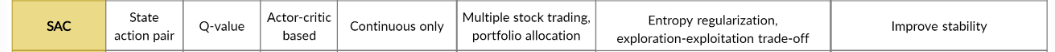

In [12]:
print("==============Model Training===========")
now = datetime.datetime.now().strftime("%Y%m%d-%Hh%M")

model_sac = agent.get_model("sac")
trained_sac = agent.train_model(model=model_sac, tb_log_name="sac", total_timesteps=80000 )

==============Model Training===========
{'batch_size': 64, 'buffer_size': 100000, 'learning_rate': 0.0001, 'learning_starts': 100, 'ent_coef': 'auto_0.1'}
Using cuda device
Logging to tensorboard_log/sac/sac_1


KeyboardInterrupt: ignored

#Save Model

In [ ]:
!mkdir -p saved_model
trained_sac.save('saved_model/my_model') 

In [ ]:
print("==============Start Trading===========")
e_trade_gym = StockTradingEnv(df=trade, turbulence_threshold=250, **env_kwargs)

df_account_value, df_actions = DRLAgent.DRL_prediction( model=trained_sac, environment = e_trade_gym)


In [ ]:
import os
cwd = os.getcwd()
cwd

In [ ]:
import os
os.chdir('/content/saved_model')


with open("./" + "/df_account_value_" + now + ".csv", 'a') as f1:
    df_account_value.to_csv(f1, header=False)

with open("./"+ "/df_actions_" + now + ".csv", 'a') as f2:
    df_actions.to_csv(f2, header=False)




#Backtesting 

In [ ]:
print("==============Get Backtest Results===========")
perf_stats_all = backtest_stats(df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./" +"/perf_stats_all_" + now + ".csv")


 #Understanding Format of Variables:

In [ ]:
train

In [ ]:
trade

In [ ]:
e_train_gym

In [ ]:
agent

In [ ]:
model_sac

In [ ]:
trained_sac

In [ ]:
e_trade_gym

In [ ]:
df_account_value

In [ ]:
df_actions